In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jcartus/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Prepare Dataset 

In [3]:
data_path = "../../dataset/400"
postfix = "400"

dim = 26

S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))
F = np.load(join(data_path, "F" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))

In [4]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset

BATCH_SIZE = 32

s_triu = extract_triu_batch(S, dim)
p_triu = extract_triu_batch(P, dim)

s_triu_norm, mu, std = AbstractDataset.normalize(s_triu)

#dataset = tf.data.Dataset.from_tensor_slices((s_triu_norm, p_triu))
#dataset.batch(BATCH_SIZE).repeat()

data= (s_triu_norm, p_triu)

#ind_validation = int(np.ceil(0.8 * len(S)))
#train = (s_triu_norm[:ind_validation], p_triu[:ind_validation])
#validation = (s_triu_norm[ind_validation:], p_triu[ind_validation:])

#train.batch(BATCH_SIZE).repeat()
#validation.batch(BATCH_SIZE).repeat()




# Test Utilities 

In [6]:
def build_model(activation, n_layers):
    model = keras.Sequential()
    
    # input layer
    model.add(keras.layers.Dense(dim_triu, activation, input_dim=dim_triu))
    
    # hidden layers
    for i in range(n_layers):
        model.add(keras.layers.Dense(dim_triu, activation))
    
    #output
    model.add(keras.layers.Dense(dim_triu))
    
    model.compile(optimizer=tf.train.AdamOptimizer(0.01), loss='MSE', metrics=['mae'])
    
    return model

In [69]:
N_TESTS = 5
EPOCHS = 10000

early_stopping = keras.callbacks.EarlyStopping(monitor="val_mean_absolute_error", min_delta=5e-3, patience=5)

def test_model(n_layers, activation, n_tests=N_TESTS, epochs=EPOCHS):
    min_mae = []
    
    for i in range(n_tests):
        
        model = build_model(activation, layer)
        history = model.fit(data[0], data[1], epochs=epochs, validation_split=0.2, verbose=0, callbacks=[early_stopping])
        
        min_mae.append(np.min(history.history["val_mean_absolute_error"]))
        
        print(" - Test " + str(i+1) + ": " + str(min_mae[-1]))
    
    return min_mae

def run_layer_test_series(activation, layers):
    error = []
    for layer in layers:
        print("Layers: " + str(layer))
        error.append(test_model(layer, activation))
    return error

# Testing 

In [70]:
layers = [2, 4, 6, 10, 15]

In [71]:
mae_elu = run_layer_test_series('elu', layers)

Layers: 2
 - Test 1: 0.29602374173392937
 - Test 2: 0.2982772837493045
 - Test 3: 0.30300367962230335
 - Test 4: 0.2976743822748011
 - Test 5: 0.29623397076425473
Layers: 4
 - Test 1: 0.31212324076447606
 - Test 2: 0.29581759685327197
 - Test 3: 0.29620830111267155
 - Test 4: 0.30428011358276874
 - Test 5: 0.2910728952116218
Layers: 6
 - Test 1: 0.29784041372212494
 - Test 2: 0.29671070299857905
 - Test 3: 0.3033972614067645
 - Test 4: 0.30686181143295665
 - Test 5: 0.296159055607378
Layers: 10
 - Test 1: 0.2962838386701158
 - Test 2: 0.30304396251016413
 - Test 3: 0.2927912264323432
 - Test 4: 0.28670895124269913
 - Test 5: 0.297175712329297
Layers: 15
 - Test 1: 0.30037788738889143
 - Test 2: 0.3008864861874541
 - Test 3: 0.2967762560391229
 - Test 4: 0.2971033296309227
 - Test 5: 0.29810879718173633


In [72]:
mae_selu = run_layer_test_series('selu', layers)

Layers: 2
 - Test 1: 0.45033029239039774
 - Test 2: 0.42942329009702385
 - Test 3: 0.4378868866065317
 - Test 4: 0.450256195935336
 - Test 5: 0.4440347480872446
Layers: 4
 - Test 1: 0.4524356299195408
 - Test 2: 0.47241906144402246
 - Test 3: 0.42864725363156025
 - Test 4: 0.462668812471973
 - Test 5: 0.44279449463875825
Layers: 6
 - Test 1: 0.46706840666857635
 - Test 2: 0.4610422524538907
 - Test 3: 0.4483066977055605
 - Test 4: 0.45682121086711724
 - Test 5: 0.4456955635350598
Layers: 10
 - Test 1: 0.45468797934942007
 - Test 2: 0.44336698937021995
 - Test 3: 0.43828939948200196
 - Test 4: 0.4587912808272464
 - Test 5: 0.4533353440525118
Layers: 15
 - Test 1: 0.44585656159180254
 - Test 2: 0.4463162234992035
 - Test 3: 0.440402929201599
 - Test 4: 0.45321271389969126
 - Test 5: 0.43851291468320797


In [73]:
x = np.array([layer for layer in layers for i in range(N_TESTS)])

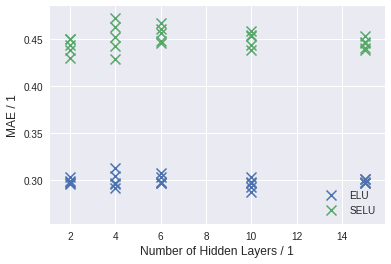

In [74]:
plt.scatter(x, np.array(mae_elu).flatten(), marker="x", label="ELU")
plt.scatter(x, np.array(mae_selu).flatten(), marker="x",  label="SELU")

plt.xlabel("Number of Hidden Layers / 1")
plt.ylabel("MAE / 1")

plt.legend()

plt.show()

In [64]:
(5e-3)**2

2.5e-05